# TP5 : Méthodes Variationnelles


---
**Khelifi Fouad**


In [51]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import time
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image
from skimage import io as skio


# POUR LA MORPHO
#from skimage.morphology import watershed
#from skimage.feature import peak_local_max

In [2]:
#%%
# VOUS DEVEZ FIXER LES DEUX VARIABLES SUIVANTES:
colaboratory = False #mettre True si vous utilisez google colab
notebook = True   # mettre Trus si vous utilisez un notebook local
# les seuls couples possibles sont (False,False)= travailler localement sans notebook
# (False,True): jupyternotebook local
# (True, False): google colab


assert (not (colaboratory and notebook)), "Erreur, choisissez google colab ou notebook local mais pas les deux en meme temps"

if colaboratory: #Si google colab on installe certaines librairies
    !pip install soundfile
    from IPython.display import Audio
    !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    !wget https://perso.telecom-paristech.fr/ladjal/donnees_IMA203.tgz
    !tar xvzf donnees_IMA203.tgz
    os.chdir('donnees_IMA203')

if notebook: # si notebook normal dans une machine locale vous devez installer bokeh vous-meme
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()

Loading BokehJS ...

In [3]:
import numpy as np
import tempfile
import IPython
import matplotlib.pyplot as plt
import PIL.Image as pil_image

def viewimage(im, normalize=True,titre='',displayfilename=False):
   imin=im.copy().astype(np.float32)
   if normalize:
       imin-=imin.min()
       if imin.max()>0:
           imin/=imin.max()
   else:
       imin=imin.clip(0,255)/255


   imin=(imin*255).astype(np.uint8)
   filename=tempfile.mktemp(titre+'.png')
   if displayfilename:
       print (filename)
   plt.imsave(filename, imin, cmap='gray')
   IPython.display.display(IPython.display.Image(filename))

#La fonction viewimage_color est la même que viewimage. Ca a l'air de marcher
#USE ONLY viewimage
def viewimage_color(im, normalize=True,titre='',displayfilename=False):
   imin=im.copy().astype(np.float32)
   if normalize:
       imin-=imin.min()
       if imin.max()>0:
           imin/=imin.max()
   else:
       imin=imin.clip(0,255)/255


   imin=(imin*255).astype(np.uint8)
   filename=tempfile.mktemp(titre+'.png')
   if displayfilename:
       print (filename)
   plt.imsave(filename, imin, cmap='gray')
   IPython.display.display(IPython.display.Image(filename))

In [4]:
#%% fonctions utiles au TP

def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out

def degrade_image(im,br):
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""

    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py):
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))

    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]

    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser
# la fonctionnelle E2 par descente de gradient nous avons choisi
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive


def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """

    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=(np.zeros((sy,sx),dtype=complex))
    denom=(np.zeros((sy,sx),dtype=complex))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I):
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax):
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))

    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))

In [5]:
# lire une image
im=imread('lena.tif') 

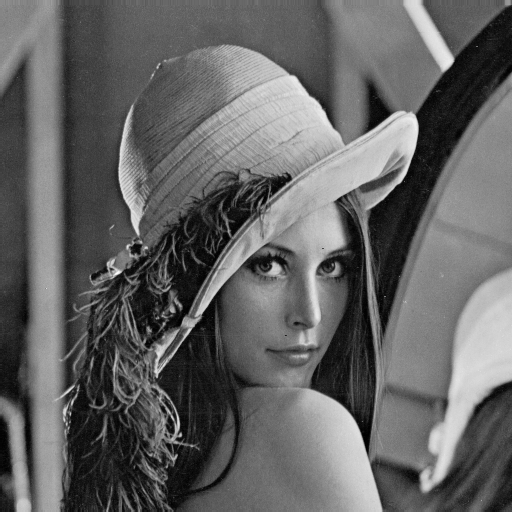

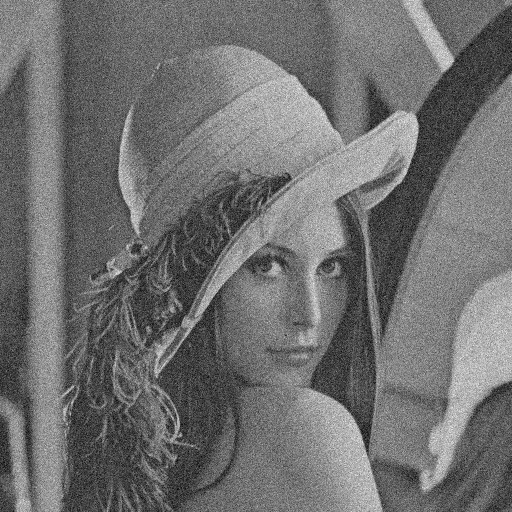

In [6]:
# voir l'image
viewimage(im,titre='ORIGINALE')

# degrader une image
im_deg = degrade_image(im,25)

# voir l'image bruitée
viewimage(imb,titre='BRUITEE')

## 1. Débruitage par régularisation quadratique

#### A1.1. 
La fonction `resoud_quad_fourier` résout le problème : 

$$
f = \arg \min_{f} \sum_{i=1}^n \| K_i \ast f - V_i \|^2
$$

En passant dans le domaine fréquentiel en utilisant l'égalité de Parseval. En transformée de Fourier, la convolution devient une multiplication, et en dérivant par rapport à $\hat{f}$ la solution optimale est :

$$
\hat{f} = \frac{\sum_{i=1}^n \overline{\hat{K}_i} \cdot \hat{V}_i}{\sum_{i=1}^n |\hat{K}_i|^2}
$$

où $ \hat{K}_i $ et $ \hat{V}_i $ sont les transformées de Fourier de $ K_i $ et $ V_i $. La solution est ramenée dans le domaine spatial avec la transformée de Fourier inverse.

La fonction `minimisation_quadratique` résout le problème :  

$$
\begin{array}{rcl}
f & = & \arg \min_{f} \left( \lambda \| \nabla f \|^2 + \| f - v \|^2 \right) \\
& = & \arg \min_{f} \left( \| \sqrt{\lambda} K_x \ast f\|^2 + \| \sqrt{\lambda} K_x \ast f\|^2 + \| f - v \|^2 \right)
\end{array}
$$

Elle construit les filtres $ K = (\sqrt{\lambda} K_x, \sqrt{\lambda} K_y, \delta) $ avec $ \nabla f $ discrétisé par $ K_x $ et $ K_y $ (gradients horizontal et vertical), et les observations $ V = (0, 0, v) $, puis appelle `resoud_quad_fourier` pour calculer $ f $ dans le domaine fréquentiel.

#### A1.2.
- **Lorsque $\lambda$ est très grand** : L'image devient excessivement floue, car seule la régularité $\lambda \|\nabla u\|^2$ prédomine. Ce terme pénalise fortement les variations, favorisant une solution lisse et uniforme. La minimisation privilégie la réduction des variations, sacrifiant les détails de l'image originale. L'image résultante est lissée, mais perd ses structures importantes.  

- **Lorsque $\lambda$ est très petit** : L'image reste proche de l'image bruitée, car la régularisation devient négligeable et l'attache aux données $\|u - v\|^2$ domine. L'objectif est alors de minimiser la différence entre $u$ et l'image bruitée $v$, avec peu d'effet sur le bruit. L'image finale conserve donc le bruit presque intact.

#### A1.3.

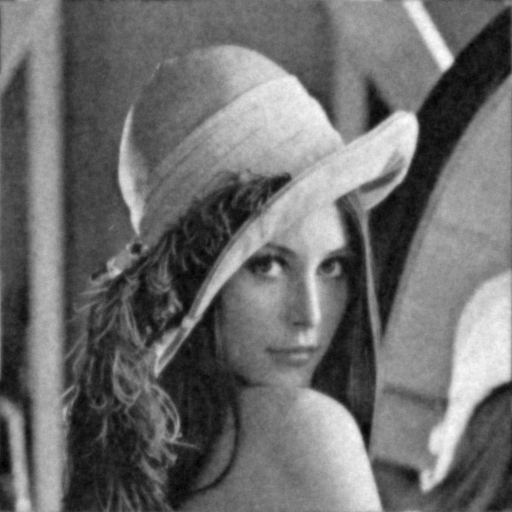

In [7]:
lamb = 3
restau = minimisation_quadratique(imb, lamb)
viewimage(restau, titre='RESTQUAD_LAMB='+ str(lamb))

In [8]:
# Fonction qui effectue la dichotomie
def best_lambda_dicho(im_deg, im, lambda_min, lambda_max, eps):
    norm_original = norm2(im_deg - im)
    err_current = float('inf')
    lambda_opt = 0

    while abs(lambda_max - lambda_min) > eps or abs(err_current - norm_original) >= 0.1:
        lambda_k = (lambda_min + lambda_max) / 2
        reconstructed_im = minimisation_quadratique(im_deg, lambda_k)
        err_current = norm2(reconstructed_im - im_deg)

        # Mise à jour des bornes en fonction de l'erreur
        if err_current - norm_original > 0:
            lambda_max = lambda_k
        else:
            lambda_min = lambda_k

        lambda_opt = lambda_k  # Sauvegarder la meilleure valeur à chaque itération

    return lambda_opt, err_current, abs(err_current - norm_original)

In [9]:
range_k = np.linspace(0, 10, 50)
erreur_reconstruction = [norm2(minimisation_quadratique(im_deg, k) - im_deg) for k in range_k]
erreur_parfaite = [norm2(im_deg - im) for _ in range_k]

# Calcul de la valeur optimale de lambda
idx_optimal = np.argmin([abs(err - erreur_parfaite[0]) for err in erreur_reconstruction])
lambda_optimal = range_k[idx_optimal]

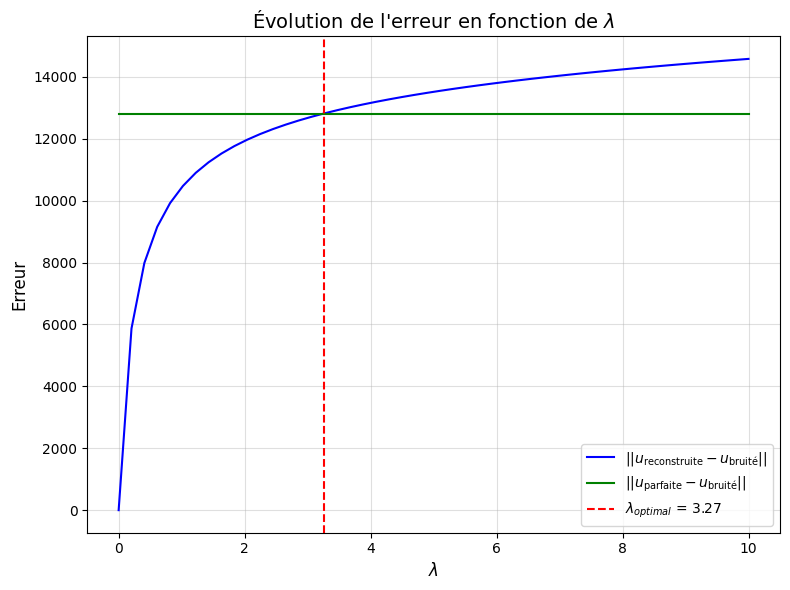

In [10]:
# Affichage
plt.figure(figsize=(8, 6))
plt.plot(range_k, erreur_reconstruction, label=r'||$u_{\text{reconstruite}} - u_{\text{bruité}}$||', color='blue')
plt.plot(range_k, erreur_parfaite, label=r'||$u_{\text{parfaite}} - u_{\text{bruité}}$||', color='green')
plt.axvline(x=lambda_optimal, color='red', linestyle='--', label=f"$\lambda_{{optimal}}$ = {lambda_optimal:.2f}")

plt.title("Évolution de l'erreur en fonction de $\lambda$", fontsize=14)
plt.xlabel(r"$\lambda$", fontsize=12)
plt.ylabel("Erreur", fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.4)
plt.tight_layout()

plt.show()

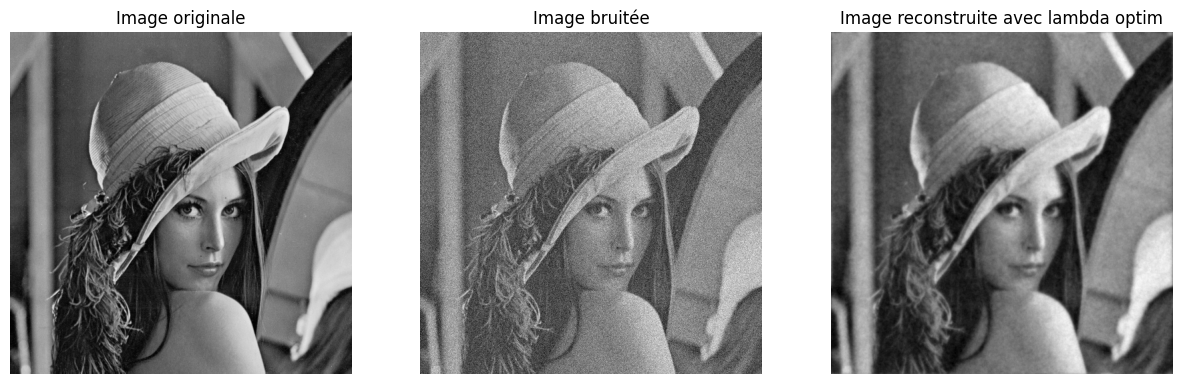

In [11]:
denoised_lena = minimisation_quadratique(im_deg, lambda_optimal)
plt.figure(figsize=(15, 5))
plt.subplot(131), plt.imshow(im, cmap='gray'), plt.title('Image originale'), plt.axis('off')
plt.subplot(132), plt.imshow(im_deg, cmap='gray'), plt.title('Image bruitée'), plt.axis('off')
plt.subplot(133), plt.imshow(denoised_lena, cmap='gray'), plt.title('Image reconstruite avec lambda optim'), plt.axis('off')
plt.show()

#### A1.4.

Pour trouver le paramètre $\lambda$ tel que $\| \tilde{u} - u \|^2$ soit minimale, on procède de manière similaire que dans **A1.3.** et on trouve la valeure optimale par dichotomie.

$\lambda$ est différent car dans la question **A1.3.**, $\lambda$ est choisi pour que l'erreur entre l'image reconstruite $\tilde{u}$ et l'image dégradée $v$ soit similaire à l'erreur entre l'image parfaite $u$ et $v$, ce qui nécessite de prendre en compte le bruit présent dans $v$. En revanche, dans la question 4, $\lambda$ est ajusté pour minimiser l'écart entre $\tilde{u}$ et $u$, sans se soucier du bruit. Ainsi, $\lambda$ est plus influencé par le bruit dans le cas de la question **A1.3.** et par la fidélité à l'image parfaite dans le cas présent.

In [12]:
def best_lambda_dicho_v2(im_deg, im, lambda_min, lambda_max, eps=0.05, max_iter=100):
    best_err = float('inf')
    best_lambda = None
    iter_count = 0
    lambdas = []  
    errors = []   

    while abs(lambda_max - lambda_min) > eps and iter_count < max_iter:
        mid_lambda = (lambda_min + lambda_max) / 2

        img = minimisation_quadratique(im_deg, mid_lambda)
        err = norm2(img - im)

        lambdas.append(mid_lambda)
        errors.append(err)
        
        if err < best_err:
            best_err = err
            best_lambda = mid_lambda
            lambda_max = mid_lambda  
        else:
            lambda_min = mid_lambda  
            
        iter_count += 1  

    print(f"Le meilleur lambda est {best_lambda:.3f} avec une erreur de {best_err:.3f}")

    return best_lambda, best_err, lambdas, errors

In [13]:
best_l, best_err, lambdas, errors = best_lambda_dicho_v2(im_deg, im, 0.01, 10, eps=0.01, max_iter=50)

Le meilleur lambda est 1.103 avec une erreur de 5325.285


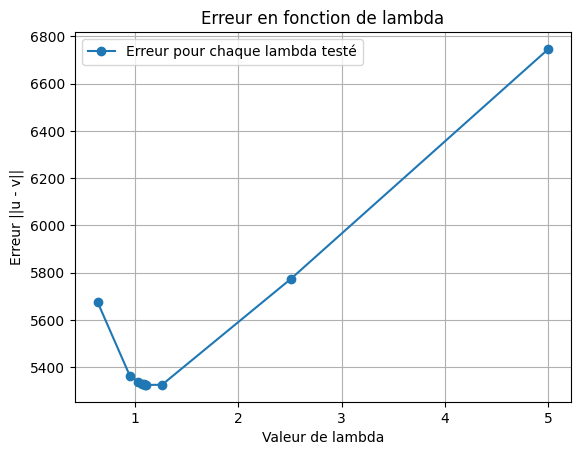

In [33]:
sorted_pairs = sorted(zip(lambdas, errors)) 
lambdas, errors = zip(*sorted_pairs)  

lambdas = list(lambdas)
errors = list(errors)

plt.plot(lambdas, errors, marker='o', label="Erreur pour chaque lambda testé") 
plt.xlabel('Valeur de lambda')
plt.ylabel('Erreur ||u - v||')
plt.title('Erreur en fonction de lambda')
plt.legend()
plt.grid(True)
plt.show()

## 2. Débruitage par variation totale

### 2.1. Descente de gradient

Si le pas de descente est trop grand, l'algorithme peut diverger, car les gradients deviennent trop importants pour permettre une convergence stable. De plus, même un pas qui ne garantit pas la divergence peut échouer à atteindre le minimum, car l'énergie associée à la variation totale n'est pas différentiable en $ u = 0 $. En conséquence, le sous-dérivé $ \partial u $ peut contenir des éléments non nuls, même au minimum, ce qui peut conduire à un minimum incorrect.

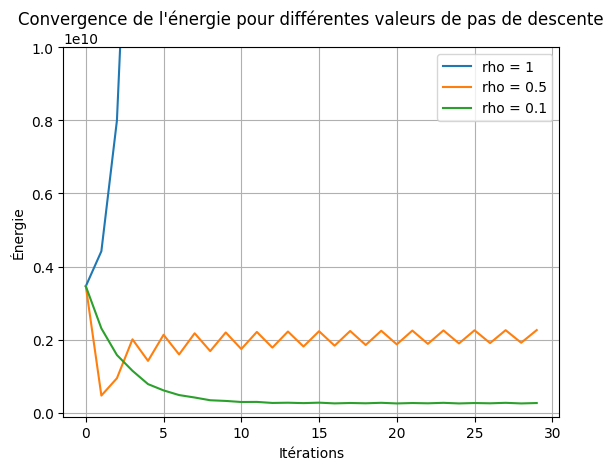

Valeurs minimales d'énergie obtenues :
rho = 1 : Énergie minimale = 3465991764.5833764
rho = 0.5 : Énergie minimale = 478168230.7341095
rho = 0.1 : Énergie minimale = 263171901.41506937


In [18]:
rhos = [1, 0.5, 0.1]
energies_dict = {}
images_dict = {}

for rho in rhos:
    u, energies = minimise_TV_gradient(imb, 40, rho, 30)
    energies_dict[rho] = energies
    images_dict[rho] = u
    plt.plot(energies, label=f'rho = {rho}')

plt.xlabel('Itérations')
plt.ylabel('Énergie')
plt.title('Convergence de l\'énergie pour différentes valeurs de pas de descente')
plt.legend()
plt.grid(True)
plt.ylim((-1e8, 1e10))
plt.show()

min_energies = {rho: min(energies) for rho, energies in energies_dict.items()}
print("Valeurs minimales d'énergie obtenues :")
for rho, min_energy in min_energies.items():
    print(f"rho = {rho} : Énergie minimale = {min_energy}")

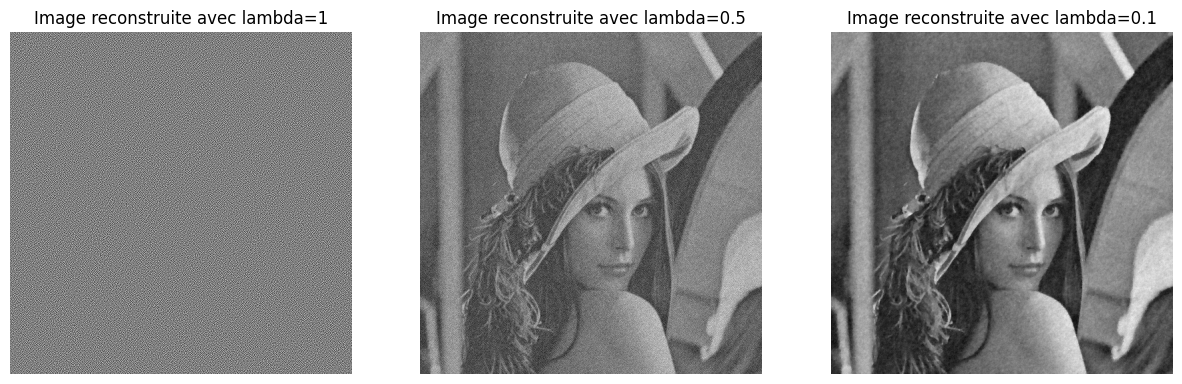

In [19]:
plt.figure(figsize=(15, 5))

for i, rho in enumerate(rhos, 1):
    plt.subplot(1, len(rhos), i) 
    plt.imshow(images_dict[rho], cmap='gray')
    plt.title(f"Image reconstruite avec lambda={rho}")
    plt.axis('off')

plt.show()

### 2.2. Projection Chambolle

La projection Chambolle est une **projection sur l'ensemble convexe $ K $** dans le cadre de la minimisation d'une fonctionnelle liée à la variation totale pour le débruitage d'images :

#### **2.2.1. Théorie de la projection sur $ K $**
**Contexte :** On cherche à minimiser une fonctionnelle TV définie par :
  $$
  \arg \min_{u} \lambda \text{TV}(u) + \frac{1}{2} \| u - g \|^2,
  $$
  où $ g $ est l'image bruitée.
  
- La minimisation est ramenée à un problème de projection sur un ensemble convexe $ K $, défini comme :
  $$
  K = \{\text{div } p \mid \|p_{i,j}\| \leq 1 \},
  $$
- Le **gradient** transforme une image en un champ de vecteurs $p$.
- La **divergence** transforme le champ de vecteurs $p$ en une image.
- La projection sur $ K $ est réalisée via un algorithme itératif basé sur le champ de vecteurs $ p^n $. Après convergence, la projection est obtenue comme la divergence du champ de vecteurs limite $ p^\infty $.

#### **2.2.2. Programmation de l'algorithme**  
#### Fonction **`projection(I, a, itmax)`**
- Calculer la projection d'une image $ I $ sur $ G_a $, une approximation de l'ensemble $ K $.
- $ p^0_x $ et $ p^0_y $, les composantes du champ de vecteurs $ p^0 $, sont initialisés à 0.
- On calcule successivement $ N $, $ G_x $, $ G_y $, qui représentent les gradients et la norme, pour mettre à jour $ p_x $ et $ p_y $.
- Ces mises à jour respectent la formule théorique :  
       $$
       p^{n+1}_{i,j} = \frac{p^n_{i,j} + \tau (\nabla (\text{div } p^n - g))_{i,j}}{1 + \tau \|\nabla (\text{div } p^n - g)\|_{i,j}}
       $$
- Après un nombre fixe d'itérations `itmax`, on obtient la projection comme la divergence du champ $ (p_x, p_y) $.

#### Fonction **`vartotale_Chambolle(v, lamb, itmax)`**
- Trouver une image minimisant $ \lambda \text{TV}(u) + \|u - v\|^2 $, où $ v $ est l'image bruitée.
- La minimisation est reformulée en projetant $ v $ sur l'ensemble $ G_a $ via la fonction **`projection`**.
- Une fois la projection $ P $ obtenue, l'image débruitée est donnée par :
    $$
    u = v - P.
    $$

In [23]:
start_time = time.time()
uchamb = vartotale_Chambolle(imb, 40, itmax=30)
end_time = time.time()

execution_time = end_time - start_time
print(f"Le temps d'exécution avec la projection de Chambolle est de {execution_time} secondes.")

Le temps d'exécution avec la projection de Chambolle est de 1.1411619186401367 secondes.


In [28]:
start_time = time.time()
udesgrad, _ = minimise_TV_gradient(imb, 40, 0.1, 30)
end_time = time.time()

execution_time = end_time - start_time
print(f"Le temps d'exécution avec la descente de gradient est de {execution_time} secondes.")

Le temps d'exécution avec la descente de gradient est de 1.592536211013794 secondes.


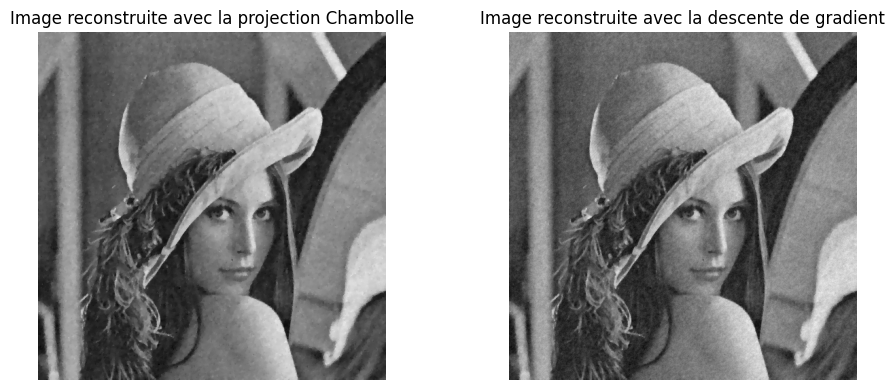

In [29]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1), plt.imshow(uchamb, cmap='gray'), plt.title('Image reconstruite avec la projection Chambolle'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(udesgrad, cmap='gray'), plt.title('Image reconstruite avec la descente de gradient'), plt.axis('off')

plt.tight_layout()
plt.show()

- L'algorithme s'éxécute plus rapidement que la descente de gradient. La méthode de Chambolle est conçue pour prendre en compte la structure de la norme TV, permettant l'utilisation de tailles de pas plus grandes sans dépasser, ce qui se traduit par une convergence plus rapide.

- L'algorithme de Chambolle permet généralement d'atteindre une minimisation plus précise de l'énergie car il traite directement la non-différentiabilité de la norme TV . L'étape itérative de projection de l'algorithme garantit que la solution reste dans l'ensemble réalisable de la norme TV, favorisant ainsi une minimisation plus précise.

## 3. Comparaison

Après avoir fixé une image bruitée par un bruit de 25. Trouver pour chacune des deux méthodes (TV et quadratique) le meilleur paramètre $\lambda$

In [36]:
def best_lambda_dicho_TV(im_deg, im, lambda_min, lambda_max, eps=0.05, max_iter=100):
    best_err = float('inf')
    best_lambda = None
    iter_count = 0
    lambdas = []  
    errors = []   

    while abs(lambda_max - lambda_min) > eps and iter_count < max_iter:
        mid_lambda = (lambda_min + lambda_max) / 2

        img = vartotale_Chambolle(im_deg, mid_lambda, itmax=30)
        err = norm2(img - im)

        lambdas.append(mid_lambda)
        errors.append(err)
        
        if err < best_err:
            best_err = err
            best_lambda = mid_lambda
            lambda_max = mid_lambda  
        else:
            lambda_min = mid_lambda  
            
        iter_count += 1  

    print(f"Le meilleur lambda est {best_lambda:.3f} avec une erreur de {best_err:.3f}")

    return best_lambda, best_err, lambdas, errors

In [45]:
best_l2, best_err2, lambdas2, errors2 = best_lambda_dicho_v2(im_deg, im, 0.01, 10, eps=0.01, max_iter=50)
best_l1, best_err1, lambdas1, errors1 = best_lambda_dicho_TV(im_deg, im, 30, 90, eps=0.05, max_iter=50)

Le meilleur lambda est 1.103 avec une erreur de 5325.285
Le meilleur lambda est 44.531 avec une erreur de 4456.497


In [46]:
sorted_pairs1 = sorted(zip(lambdas1, errors1)) 
lambdas1, errors1 = zip(*sorted_pairs1)  

lambdas1 = list(lambdas1)
errors1 = list(errors1)

In [47]:
sorted_pairs2 = sorted(zip(lambdas2, errors2)) 
lambdas2, errors2 = zip(*sorted_pairs2)  

lambdas2 = list(lambdas2)
errors2 = list(errors2)

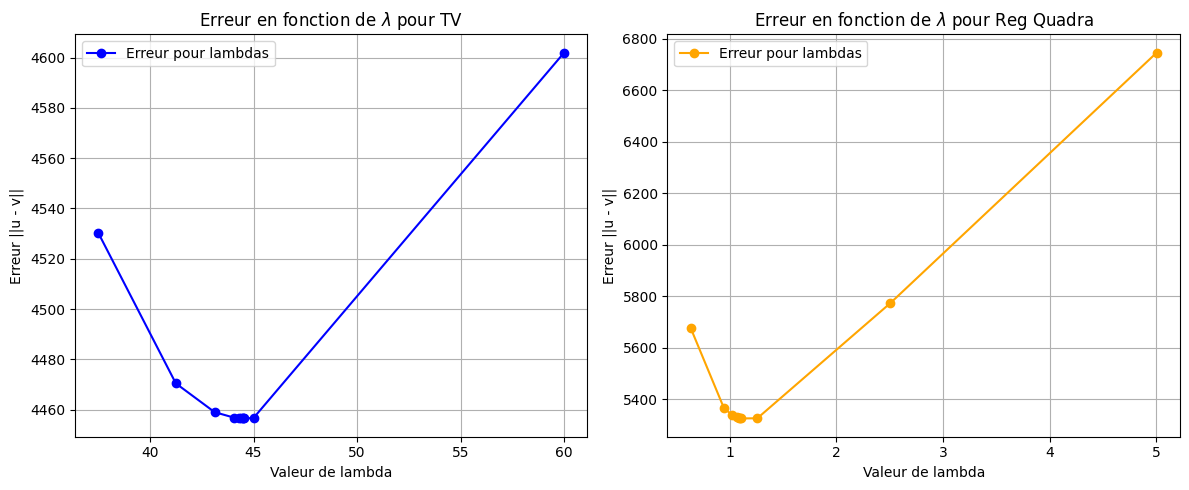

In [48]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lambdas1, errors1, marker='o', label="Erreur pour lambdas", color='blue')
plt.xlabel('Valeur de lambda')
plt.ylabel('Erreur ||u - v||')
plt.title(r'Erreur en fonction de $\lambda$ pour TV')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)  
plt.plot(lambdas2, errors2, marker='o', label="Erreur pour lambdas", color='orange')
plt.xlabel('Valeur de lambda')
plt.ylabel('Erreur ||u - v||')
plt.title(r'Erreur en fonction de $\lambda$ pour Reg Quadra')
plt.legend()
plt.grid(True)

plt.tight_layout()  
plt.show()

In [54]:
img_rq = minimisation_quadratique(im_deg, best_l2)
img_tv = vartotale_Chambolle(im_deg, best_l1, itmax=30)

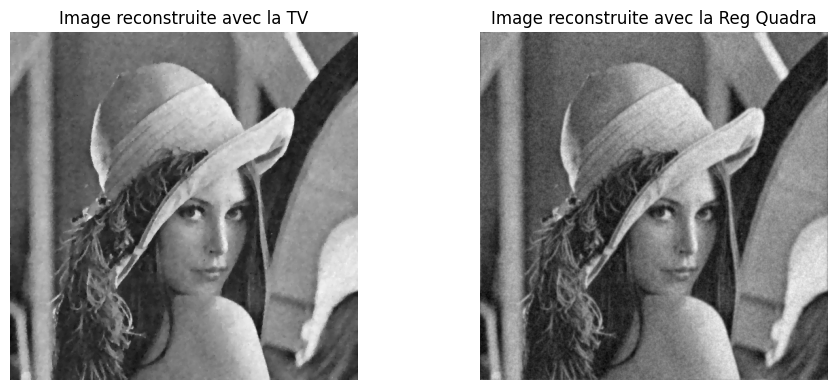

In [55]:
plt.figure(figsize=(10, 4))

plt.subplot(1,2,1), plt.imshow(img_tv, cmap='gray'), plt.title('Image reconstruite avec la TV'), plt.axis('off')
plt.subplot(1,2,2), plt.imshow(img_rq, cmap='gray'), plt.title('Image reconstruite avec la Reg Quadra'), plt.axis('off')

plt.tight_layout()
plt.show()

**Conclusion** : Le lambda optimal pour la régularisation quadratique, qui minimise l'erreur $\|u - v\|$, n'atténue pas le bruit de manière aussi efficace que la régularisation par variation totale (TV). En effet, si ce lambda réduisait le bruit de façon similaire à la régularisation TV, les détails fins, notamment ceux liés aux contours et aux petites structures de l'image, seraient floutés, ce qui augmenterait l'erreur. La régularisation TV se distingue par sa capacité à préserver ces détails de haute fréquence tout en supprimant le bruit, ce qui en fait une méthode plus adaptée pour ce type de problématique. Cependant, cette approche est plus complexe à mettre en œuvre en raison de la non-différentiabilité de la fonction que l'on cherche à minimiser.